<a href="https://colab.research.google.com/github/RushitJetani/Cancer-Detection/blob/main/Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install split-folders

In [ ]:
## Perform standard imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
## Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Normalizes to range [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    transforms.Resize((224, 224))  # Resize images to 224x224 for ResNet
])

In [ ]:
## Set working directory to the dataset location
%cd /content/drive/MyDrive/PythonScripts/Assign03

/content/drive/MyDrive/PythonScripts/Assign03


In [ ]:
## Prepare train and test sets, loaders
train_data = datasets.ImageFolder('Covid19-dataset/train', transform=transform)
test_data = datasets.ImageFolder('Covid19-dataset/test', transform=transform)

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, drop_last=True)

In [ ]:
# Get class names
class_names = train_data.classes
print(f"Class names: {class_names}")
print(f"Training images available: {len(train_data)}")
print(f"Testing images available: {len(test_data)}")

Class names: ['Covid', 'Normal', 'Viral Pneumonia']
Training images available: 251
Testing images available: 66


In [ ]:
## Display a batch of images
for images, labels in train_loader:
    break
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
# Print the labels
print('Labels:', labels.numpy())
print('Classes:', *np.array([class_names[i] for i in labels]))

Labels: [0 1 1 1 1 0 1 0 1 0 2 0 2 2 1 2 1 2 2 0 1 0 1 2 2 2 1 1 1 0 0 2]
Classes: Covid Normal Normal Normal Normal Covid Normal Covid Normal Covid Viral Pneumonia Covid Viral Pneumonia Viral Pneumonia Normal Viral Pneumonia Normal Viral Pneumonia Viral Pneumonia Covid Normal Covid Normal Viral Pneumonia Viral Pneumonia Viral Pneumonia Normal Normal Normal Covid Covid Viral Pneumonia


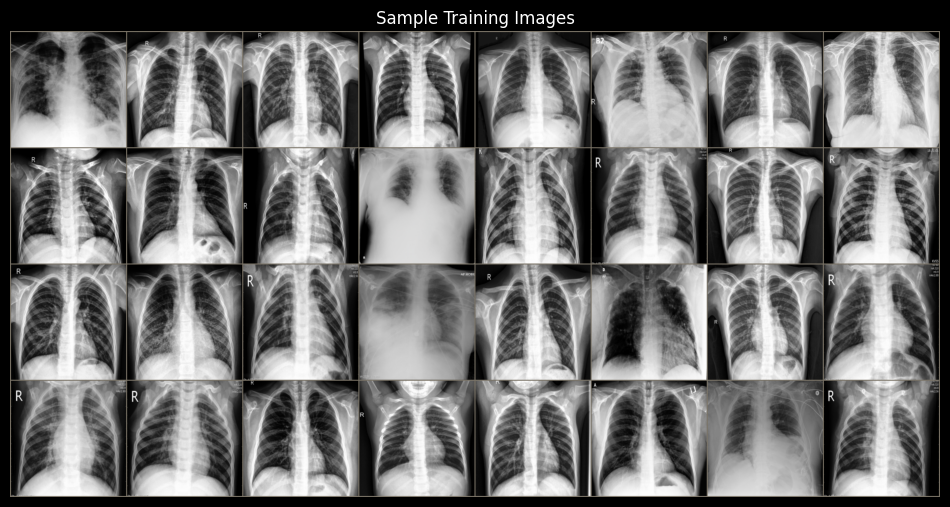

In [ ]:
# Inverse normalize the images for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(make_grid(images, nrow=8))

# Display the images
plt.figure(figsize=(12, 8))
plt.imshow(np.transpose((im_inv.numpy() * 255).astype(np.uint8), (1, 2, 0)))
plt.title("Sample Training Images")
plt.axis('off')
plt.show()

In [ ]:
## Import and modify ResNet-18
resnet = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
# Modify the final layer for 3 classes (Covid, Viral Pneumonia, Normal)
resnet.fc = nn.Linear(resnet.fc.in_features, 3)

In [ ]:
# Move model to device
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Print model summary
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
## Training and Testing the model
epochs = 10

# Loss function
lossfunc = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(resnet.parameters(), momentum=0.9, lr=0.001)

# Initialize losses and accuracies
losses = torch.zeros(epochs)
trainAcc = []
testAcc = []

# Training loop
for epoch in range(epochs):
    resnet.train()
    batchAcc = []
    batchLoss = []

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        ypred = resnet(X)
        loss = lossfunc(ypred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append batch loss
        batchLoss.append(loss.item())

        # Compute batch accuracy
        ypred = ypred.cpu()
        y = y.cpu()
        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc)

    # Average training accuracy and loss for the epoch
    trainAcc.append(np.mean(batchAcc))
    losses[epoch] = np.mean(batchLoss)

    # Testing the model
    resnet.eval()
    X, y = next(iter(test_loader))
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
        ypred = resnet(X)
        ypred = ypred.cpu()
        y = y.cpu()

        # Compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(ypred, dim=1) == y).float()))

    print(f"Epoch: {epoch+1}/{epochs}, Loss: {losses[epoch]:.4f}, Train Acc: {trainAcc[-1]:.2f}%, Test Acc: {testAcc[-1]:.2f}%")

Epoch: 1/10, Loss: 1.2158, Train Acc: 31.70%, Test Acc: 56.25%
Epoch: 2/10, Loss: 0.9436, Train Acc: 56.25%, Test Acc: 50.00%
Epoch: 3/10, Loss: 0.6985, Train Acc: 83.48%, Test Acc: 96.88%
Epoch: 4/10, Loss: 0.5468, Train Acc: 87.05%, Test Acc: 96.88%
Epoch: 5/10, Loss: 0.4147, Train Acc: 92.41%, Test Acc: 96.88%
Epoch: 6/10, Loss: 0.3709, Train Acc: 90.62%, Test Acc: 90.62%
Epoch: 7/10, Loss: 0.3337, Train Acc: 92.86%, Test Acc: 93.75%
Epoch: 8/10, Loss: 0.3030, Train Acc: 92.86%, Test Acc: 90.62%
Epoch: 9/10, Loss: 0.3183, Train Acc: 91.07%, Test Acc: 90.62%
Epoch: 10/10, Loss: 0.2652, Train Acc: 93.75%, Test Acc: 93.75%


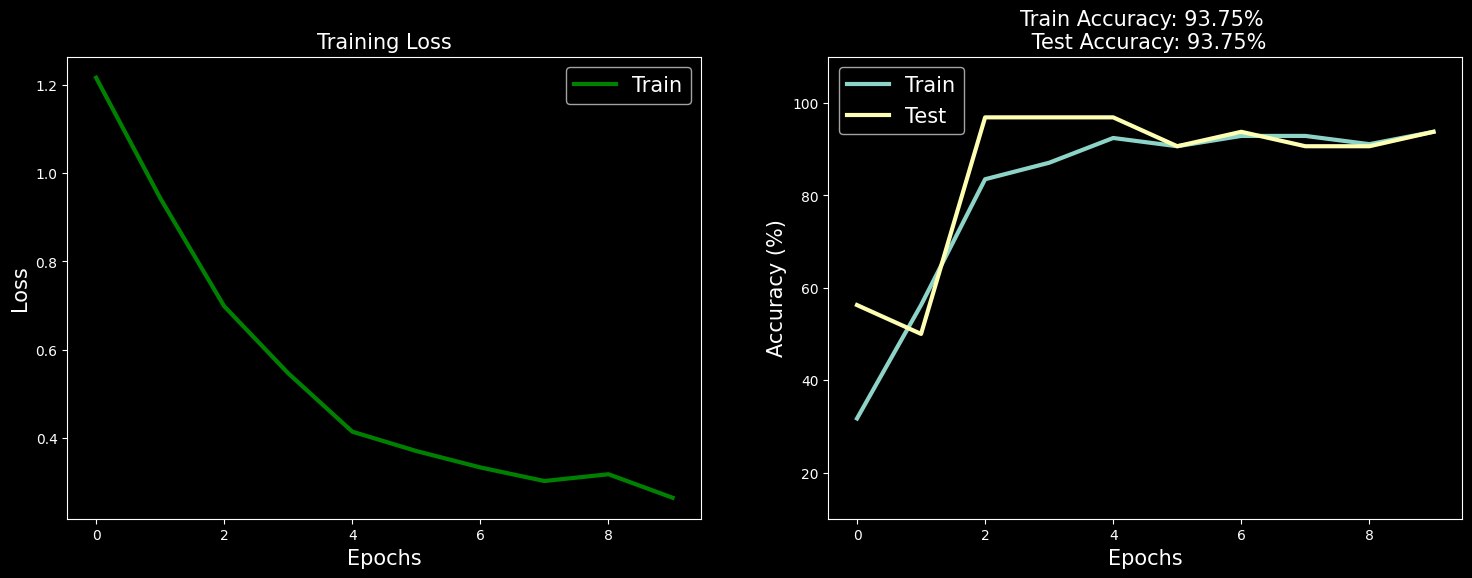

In [ ]:
## Plot results
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot training loss
ax[0].plot(losses, 'g', lw=3, label='Train')
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend(fontsize=15)
ax[0].set_title('Training Loss', fontsize=15)

# Plot training and test accuracy
ax[1].plot(trainAcc, label='Train', lw=3)
ax[1].plot(testAcc, label='Test', lw=3)
ax[1].set_xlabel('Epochs', fontsize=15)
ax[1].set_ylabel('Accuracy (%)', fontsize=15)
ax[1].set_ylim([10, 110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize=15)
ax[1].legend(fontsize=15)

plt.show()